In [ ]:
pip install torch===1.8.1 torchvision===0.9.1 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████▏                          | 130.8MB 1.7MB/s eta 0:06:26
ERROR: Operation cancelled by user


In [ ]:
import torch
print(torch.version.cuda)

10.1


In [ ]:
pip install dgl-cu102

     |████████████████████████████████| 36.8MB 1.3MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import dgl
import os

In [ ]:
import torch
import torch.nn as nn
import re
import spacy
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import string
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error
from datetime import datetime

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import column_or_1d
from sklearn.model_selection import train_test_split
from torch.utils.data.dataset import Subset
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
syllable_df_Nest_Total1 = pd.read_pickle('/content/gdrive/My Drive/ZFDataset/Nest1_Densenet121.pkl')
syllable_df_Nest_Total1['Nest'] = "Nest1"
syllable_df_Nest_Total2 = pd.read_pickle('/content/gdrive/My Drive/ZFDataset/Nest2_Densenet121.pkl')
syllable_df_Nest_Total2['Nest'] = "Nest2"
syllable_df_Nest_Total3 = pd.read_pickle('/content/gdrive/My Drive/ZFDataset/Nest3_Densenet121.pkl')
syllable_df_Nest_Total3['Nest'] = "Nest3"
syllable_df_Nest_Total4 = pd.read_pickle('/content/gdrive/My Drive/ZFDataset/Nest4_Densenet121.pkl')
syllable_df_Nest_Total4['Nest'] = "Nest4"
syllable_df_Nest_Total5 = pd.read_pickle('/content/gdrive/My Drive/ZFDataset/Nest5_Densenet121.pkl')
syllable_df_Nest_Total5['Nest'] = "Nest5"

In [ ]:
syllable_df_Nest_Total = pd.concat([syllable_df_Nest_Total1, syllable_df_Nest_Total2, syllable_df_Nest_Total3, syllable_df_Nest_Total4, syllable_df_Nest_Total5], ignore_index=True)
del syllable_df_Nest_Total1, syllable_df_Nest_Total2, syllable_df_Nest_Total3, syllable_df_Nest_Total4, syllable_df_Nest_Total5

In [ ]:
syllable_df_Nest_Total

,start_time,end_time,labels,indv,indvi,key,audio,rate,spectrogram,labels_indv,densenet121_features,Nest
0,0.103084,0.133787,-,cyea,1,cyea_0000,"[-0.0037507678, -0.0037730576, -0.0033396403, ...",44100,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",cyea_-,"[0.00036964213, 0.0061388216, 0.0023623325, 0....",Nest1
1,0.197664,0.342063,a,cyea,2,cyea_0000,"[-0.0016009295, -0.00080086064, 0.00024397256,...",44100,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",cyea_a,"[0.00039546576, 0.0042689457, 0.0021646945, 0....",Nest1
2,0.369546,0.536848,b,cyea,3,cyea_0000,"[0.0028250518, 0.0025573175, 0.002130959, 0.00...",44100,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",cyea_b,"[0.00043923515, 0.0035873966, 0.0023025582, 0....",Nest1
3,0.559955,0.687823,c,cyea,4,cyea_0000,"[0.00036472746, 0.00013401418, -0.00052369735,...",44100,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",cyea_c,"[0.0004885812, 0.0055127405, 0.0017675881, 0.0...",Nest1
4,0.726644,0.832925,d,cyea,5,cyea_0000,"[0.0033374317, 0.004109387, 0.003555804, 0.002...",44100,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",cyea_d,"[0.00040706727, 0.004342597, 0.0018088806, 0.0...",Nest1
...,...,...,...,...,...,...,...,...,...,...,...,...
11286,3.072562,3.280658,0,ttog,12,ttog_0035,"[-0.00018394654, -0.0013606688, -0.0018586811,...",44100,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",ttog_0,"[0.00044240133, 0.0058716596, 0.0016218609, 0....",Nest5
11287,3.523469,3.590385,0,ttog,13,ttog_0035,"[0.00424844, 0.0033519259, 0.0020941892, 0.001...",44100,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",ttog_0,"[0.00038072543, 0.0063214703, 0.0022345975, 0....",Nest5
11288,3.610907,3.688322,0,ttog,14,ttog_0035,"[0.0036732603, 0.0029418766, 0.0014781265, 0.0...",44100,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",ttog_0,"[0.0003869663, 0.006349039, 0.0021536914, 0.00...",Nest5
11289,3.714921,4.134331,0,ttog,15,ttog_0035,"[-0.0048942175, -0.006281676, -0.0066523557, -...",44100,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",ttog_0,"[0.00043150302, 0.0055522835, 0.0034172744, 0....",Nest5


In [ ]:
Tutor_dataset = syllable_df_Nest_Total[syllable_df_Nest_Total['indv'].isin(["ivoj", "nzen", "xsup", "gthh", "ttog"])].reset_index(drop=True)

In [ ]:
Pupil_dataset = syllable_df_Nest_Total[syllable_df_Nest_Total['indv'].isin(["hphi", "cyea", "phpd", "cxyc", "qfod", "nsrn", "khxv", "oogw", "kcos", "tbfk"])].reset_index(drop=True)

In [ ]:
temp2 = pd.read_csv('Nest_Total_upload.csv')

In [ ]:
temp2

,indv,indvi,key,densenet121_features,Nest
0,cyea,1,cyea_0000,[3.6964213e-04 6.1388216e-03 2.3623325e-03 ......,Nest1
1,cyea,2,cyea_0000,[3.9546576e-04 4.2689457e-03 2.1646945e-03 ......,Nest1
2,cyea,3,cyea_0000,[4.3923515e-04 3.5873966e-03 2.3025582e-03 ......,Nest1
3,cyea,4,cyea_0000,[4.8858119e-04 5.5127405e-03 1.7675881e-03 ......,Nest1
4,cyea,5,cyea_0000,[4.0706727e-04 4.3425970e-03 1.8088806e-03 ......,Nest1
...,...,...,...,...,...
11286,ttog,12,ttog_0035,[4.4240133e-04 5.8716596e-03 1.6218609e-03 ......,Nest5
11287,ttog,13,ttog_0035,[3.8072543e-04 6.3214703e-03 2.2345975e-03 ......,Nest5
11288,ttog,14,ttog_0035,[3.8696631e-04 6.3490388e-03 2.1536914e-03 ......,Nest5
11289,ttog,15,ttog_0035,[4.3150302e-04 5.5522835e-03 3.4172744e-03 ......,Nest5


In [ ]:
def create_sequence_feature(syllable_df_Nest_Total, given_key, encoder, label_select='indv'):
    current_songfile = syllable_df_Nest_Total.loc[syllable_df_Nest_Total['key']==given_key]
    sequence_length = current_songfile['indvi'].values[-1]
    temp_list = current_songfile['densenet121_features'].to_list()
    label = encoder.transform(current_songfile[label_select].values)[-1]
    # for k in range(sequence_length,max_sequence_length):
    #   temp_list.append(np.zeros(len(temp_list[0])))
    return [temp_list, sequence_length], label

In [ ]:
def data_splitting_based_on_sample_size(syllable_df_Nest_Total):
  Label_Total = []
  Nest_Total = []

  for key in syllable_df_Nest_Total.key.unique():
    Label_Total.append(syllable_df_Nest_Total.loc[syllable_df_Nest_Total['key']==key]['indv'].values[0])
    Nest_Total.append(syllable_df_Nest_Total.loc[syllable_df_Nest_Total['key']==key]['Nest'].values[0])

  le = LabelEncoder()
  le.fit(Nest_Total)

  targets = le.transform(Nest_Total)

  encoded_targets = pd.DataFrame({'targets' : targets,
        'indvi' : Label_Total,
        'key' : syllable_df_Nest_Total.key.unique(),
        'Nest' : Nest_Total})

  # train_indices, test_indices = train_test_split(np.arange(targets.shape[0]), train_size=train_test_split_ratio, stratify=targets)

  # train_keys = encoded_targets.loc[train_indices]['key'].to_list()

  # test_keys = encoded_targets.loc[test_indices]['key'].to_list()

  # return encoded_targets, train_keys, test_keys, le
  return encoded_targets, le

In [ ]:
class LSTM_fixed_len(torch.nn.Module) :
    # def __init__(self, vocab_size, embedding_dim, hidden_dim) :
    def __init__(self, embedding_dim, hidden_dim, output_dim, num_layers) :
        super().__init__()
        # self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim) # Bias = true
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        # x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [ ]:
class ReviewsDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx][0]), self.y[idx], self.X[idx][1]

In [ ]:
encoded_targets, le = data_splitting_based_on_sample_size(Tutor_dataset)

In [ ]:
encoded_targets_test, le_test = data_splitting_based_on_sample_size(Tutor_dataset)

X_test = []; y_test = [];

for key in encoded_targets_test['key'].unique():# [:10]:
    print(key)
    data, label = create_sequence_feature(Tutor_dataset, key, le, label_select='Nest')
    X_test.append(data)
    y_test.append(label)

test_ds = ReviewsDataset(X_test, y_test)

ivoj_0000
ivoj_0001
ivoj_0002
ivoj_0003
ivoj_0004
ivoj_0005
ivoj_0006
nzen_0000
nzen_0001
nzen_0002
nzen_0003
nzen_0004
nzen_0005
nzen_0006
nzen_0007
nzen_0008
nzen_0009
nzen_0010
nzen_0011
nzen_0012
nzen_0013
nzen_0014
nzen_0015
nzen_0016
xsup_0000
xsup_0001
xsup_0002
xsup_0003
xsup_0004
xsup_0005
xsup_0006
xsup_0007
xsup_0008
xsup_0009
xsup_0010
xsup_0011
xsup_0012
xsup_0013
xsup_0014
xsup_0015
xsup_0016
xsup_0017
xsup_0018
xsup_0019
xsup_0020
xsup_0021
xsup_0022
xsup_0023
xsup_0024
xsup_0025
xsup_0026
xsup_0027
xsup_0028
xsup_0029
xsup_0030
xsup_0031
xsup_0032
xsup_0033
xsup_0034
xsup_0035
xsup_0036
xsup_0037
xsup_0038
gthh_0000
gthh_0001
gthh_0002
gthh_0003
gthh_0004
gthh_0005
gthh_0006
gthh_0007
gthh_0008
gthh_0009
gthh_0010
gthh_0011
gthh_0012
gthh_0013
gthh_0014
gthh_0015
gthh_0016
gthh_0017
gthh_0018
gthh_0019
gthh_0020
gthh_0021
gthh_0022
gthh_0023
gthh_0024
gthh_0025
gthh_0026
gthh_0027
gthh_0028
gthh_0029
gthh_0030
gthh_0031
gthh_0032
gthh_0033
ttog_0000
ttog_0001
ttog_0002


In [ ]:
class LSTM_fixed_len(torch.nn.Module) :
    # def __init__(self, vocab_size, embedding_dim, hidden_dim) :
    def __init__(self, embedding_dim, hidden_dim, output_dim, num_layers) :
        super().__init__()
        # self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim) # Bias = true
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        # x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [ ]:
encoded_targets

,targets,indvi,key,Nest
0,0,ivoj,ivoj_0000,Nest1
1,0,ivoj,ivoj_0001,Nest1
2,0,ivoj,ivoj_0002,Nest1
3,0,ivoj,ivoj_0003,Nest1
4,0,ivoj,ivoj_0004,Nest1
...,...,...,...,...
128,4,ttog,ttog_0031,Nest5
129,4,ttog,ttog_0032,Nest5
130,4,ttog,ttog_0033,Nest5
131,4,ttog,ttog_0034,Nest5


In [ ]:
# model = torch.load('/content/gdrive/My Drive/ZFDataset/SavedModels/LSTM/LayerNum2_1024_16_5_epoch100_CV5_TutorTest/Overall_Fold1_13_05_2021_19_17_Train_1.0_Val_1.0_Test_0.9549')
model = torch.load('/content/gdrive/My Drive/ZFDataset/SavedModels/LSTM/Unidirectional/NHL1_1024_16_5_25_epoch_10_CV/Overall_Fold2_24_05_2021_18_45_Train_1.0_Val_1.0_Test_0.7895')
model.eval()

LSTM_fixed_len(
  (lstm): LSTM(1024, 16, batch_first=True)
  (linear): Linear(in_features=16, out_features=5, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
Hidden_layer =[]
Hidden_layer_labels = []
actual_label = []
predicted_label = []

for x, y, l in test_ds:
  x = x.float()
  x.resize_((1,x.shape[0],x.shape[1]))
  lstm_out, (ht, ct) = model.lstm(x)
  Hidden_layer.append(ht[-1].detach().numpy().reshape(16, ))
  Hidden_layer_labels.append(y)

  y = torch.tensor(y).long().resize_((1))
  y_hat = model(x)
  pred = torch.max(y_hat, 1)[1]
  actual_label.extend(y.numpy())
  predicted_label.extend(pred.numpy())
conf_mat_lstm = confusion_matrix(actual_label, predicted_label)
accuracy_score(actual_label, predicted_label)

0.7368421052631579

In [ ]:
conf_mat_lstm

array([[ 7,  0,  0,  0,  0],
       [ 0, 17,  0,  0,  0],
       [ 0, 13, 26,  0,  0],
       [ 0, 20,  0, 14,  0],
       [ 2,  0,  0,  0, 34]])

In [ ]:
len(Hidden_layer)

133

In [ ]:
len(Hidden_layer_labels)

133

In [ ]:
hover_data = pd.DataFrame(le.inverse_transform((Hidden_layer_labels)), columns=['Nest'])
hover_data['key'] = encoded_targets['key']

In [ ]:
hover_data

,Nest,key
0,Nest1,ivoj_0000
1,Nest1,ivoj_0001
2,Nest1,ivoj_0002
3,Nest1,ivoj_0003
4,Nest1,ivoj_0004
...,...,...
128,Nest5,ttog_0031
129,Nest5,ttog_0032
130,Nest5,ttog_0033
131,Nest5,ttog_0034


In [ ]:
pip install umap-learn

     |████████████████████████████████| 81kB 2.9MB/s 
     |████████████████████████████████| 1.2MB 5.9MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=8ceba6a7a33b3197d73ecdea11e101e2c4a78ea3d494cd65d5bc633b7e2cbdd1
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=4a48e562f89ec993b36606e111f9365764ad6c6c9034517a9d8f5b510fef9773
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
Successfully built umap-learn pynndescent


In [ ]:
import umap.umap_ as umap

In [ ]:
embedding = umap.UMAP(n_neighbors = 50, min_dist=0.05, random_state=2021, densmap=True).fit(Hidden_layer)

In [ ]:
pip install umap-learn[plot]

     |████████████████████████████████| 15.8MB 315kB/s 
     |████████████████████████████████| 81kB 8.0MB/s 
     |████████████████████████████████| 112kB 37.1MB/s 
     |████████████████████████████████| 706kB 32.9MB/s 
  Created wheel for datashape: filename=datashape-0.5.2-cp37-none-any.whl size=59430 sha256=6e2440327495f6cc2ff703063b53a24f767599802a30e23ce7d09d89374d6988
  Stored in directory: /root/.cache/pip/wheels/8d/06/05/c1cba3d57bdcfd3960e3f60a9fdc97e4baef2ef09af0ad1ef8
Successfully built datashape
ERROR: distributed 2021.5.0 has requirement cloudpickle>=1.5.0, but you'll have cloudpickle 1.3.0 which is incompatible.
ERROR: distributed 2021.5.0 has requirement dask==2021.05.0, but you'll have dask 2.12.0 which is incompatible.
  Found existing installation: distributed 1.25.3
    Uninstalling distributed-1.25.3:
      Successfully uninstalled distributed-1.25.3


In [ ]:
import umap.plot
umap.plot.output_notebook()

In [ ]:
p = umap.plot.interactive(embedding, labels=Hidden_layer_labels, hover_data=hover_data, point_size=4) #title ='Nest1')
umap.plot.show(p)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
colors = cm.rainbow(np.linspace(0, 1, len(pd.unique(hover_data['Nest']))))

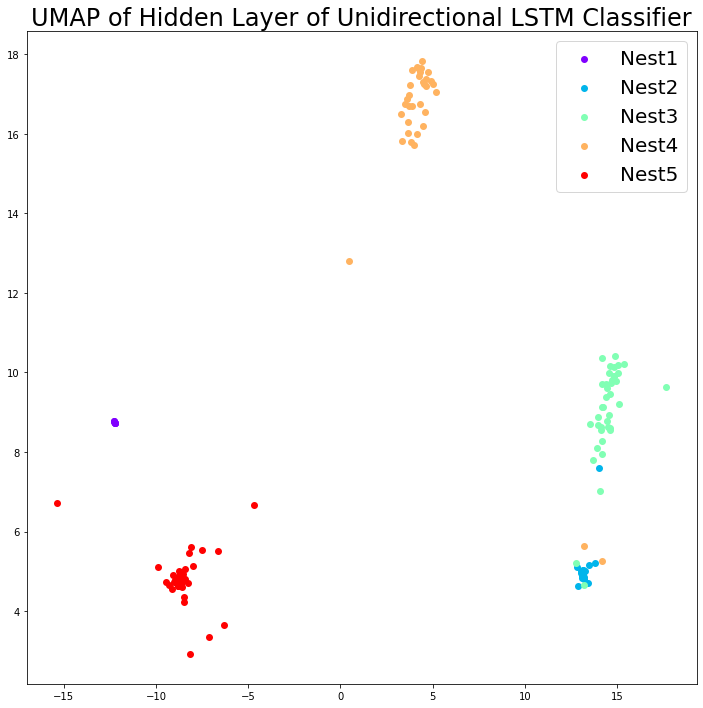

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot()

for i in range(0,len(pd.unique(hover_data['Nest']))):
    # print(i)
    label_index = (hover_data['Nest']== le.classes_[i]).values
    ax.scatter(embedding.embedding_[label_index, 0], embedding.embedding_[label_index, 1], color=colors[i], s=30, linewidth=1.5)

plt.legend(list(le.classes_), loc='best', fontsize='20')
plt.title('UMAP of Hidden Layer of Unidirectional LSTM Classifier', fontsize='24')
plt.show()

In [ ]:
conf_mat_lstm

array([[ 7,  0,  0,  0,  0],
       [ 0, 17,  0,  0,  0],
       [ 0, 13, 26,  0,  0],
       [ 0, 20,  0, 14,  0],
       [ 2,  0,  0,  0, 34]])

In [ ]:
colors

array([[5.00000000e-01, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.96078431e-03, 7.09281308e-01, 9.23289106e-01, 1.00000000e+00],
       [5.03921569e-01, 9.99981027e-01, 7.04925547e-01, 1.00000000e+00],
       [1.00000000e+00, 7.00543038e-01, 3.78411050e-01, 1.00000000e+00],
       [1.00000000e+00, 1.22464680e-16, 6.12323400e-17, 1.00000000e+00]])

In [ ]:
model_bidir = torch.load('/content/gdrive/My Drive/ZFDataset/SavedModels/LSTM/Bidirectional/NHL1_1024_16_5_25_epochs_10_CV/Overall_Fold1_24_05_2021_18_08_Train_1.0_Val_1.0_Test_0.9474')
# model_bidir = torch.load('/content/gdrive/My Drive/ZFDataset/SavedModels/LSTM/Bidirectional/NHL1_1024_16_5_25_epochs_10_CV/Overall_Fold2_24_05_2021_18_11_Train_1.0_Val_1.0_Test_0.9398')
model_bidir.eval()

LSTM_fixed_len(
  (lstm): LSTM(1024, 32, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=32, out_features=5, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
Hidden_layer_bidir =[]
Hidden_layer_labels_bidir = []
actual_label_bidir = []
predicted_label_bidir = []

for x, y, l in test_ds:
  x = x.float()
  x.resize_((1,x.shape[0],x.shape[1]))
  lstm_out, (ht, ct) = model_bidir.lstm(x)
  Hidden_layer_bidir.append(ht[-1].detach().numpy().reshape(32, ))
  Hidden_layer_labels_bidir.append(y)

  y = torch.tensor(y).long().resize_((1))
  y_hat = model_bidir(x)
  pred = torch.max(y_hat, 1)[1]
  actual_label_bidir.extend(y.numpy())
  predicted_label_bidir.extend(pred.numpy())
conf_mat_lstm_bidir = confusion_matrix(actual_label_bidir, predicted_label_bidir)
accuracy_score(actual_label_bidir, predicted_label_bidir)

0.849624060150376

In [ ]:
embedding_bidir = umap.UMAP(n_neighbors = 50, min_dist=0.05, random_state=2021, densmap=True).fit(Hidden_layer_bidir)

In [ ]:
import umap.plot
umap.plot.output_notebook()

p_bidir = umap.plot.interactive(embedding_bidir, labels=Hidden_layer_labels_bidir, hover_data=hover_data, point_size=4) #title ='Nest1')
umap.plot.show(p_bidir)

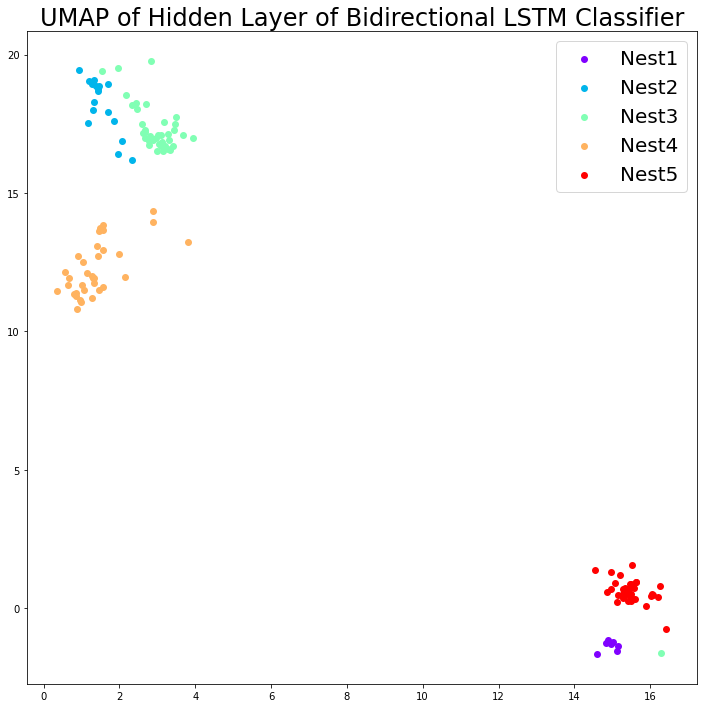

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot()

for i in range(0,len(pd.unique(hover_data['Nest']))):
    # print(i)
    label_index = (hover_data['Nest']== le.classes_[i]).values
    ax.scatter(embedding_bidir.embedding_[label_index, 0], embedding_bidir.embedding_[label_index, 1], color=colors[i], s=30, linewidth=1.5)

plt.legend(list(le.classes_), loc='best', fontsize='20')
plt.title('UMAP of Hidden Layer of Bidirectional LSTM Classifier', fontsize='24')
plt.show()

In [ ]:
conf_mat_lstm_bidir

array([[ 7,  0,  0,  0,  0],
       [ 0, 13,  4,  0,  0],
       [ 0,  7, 31,  0,  1],
       [ 0,  6,  1, 26,  1],
       [ 0,  0,  0,  0, 36]])

In [ ]:
from os import walk

In [ ]:
search_path = '/content/gdrive/My Drive/ZFDataset/SavedModels/Final Architecture/LSTM/Bidirectional/'
_, _, filenames = next(walk(search_path))

In [ ]:
Accuracy_Table = pd.DataFrame(columns=['Train Accuracy', 'Val Accuracy', 'Test Accuracy'])

for file in filenames:
  if 'Accuracy_Table_Test' in file:
    print(file)
    Acc_data = pd.read_csv(search_path+file, index_col=False)
    Acc_data = Acc_data.drop(columns=['Unnamed: 0'])
    Accuracy_Table = Accuracy_Table.append(pd.Series(Acc_data.mean(axis=0).values, index=Accuracy_Table.columns.values), ignore_index=True)

Accuracy_Table_Test_Random_2746.csv
Accuracy_Table_Test_Random_8964.csv
Accuracy_Table_Test_Random_70.csv
Accuracy_Table_Test_Random_3859.csv
Accuracy_Table_Test_Random_7857.csv
Accuracy_Table_Test_Random_7980.csv
Accuracy_Table_Test_Random_2999.csv
Accuracy_Table_Test_Random_3324.csv
Accuracy_Table_Test_Random_1778.csv
Accuracy_Table_Test_Random_329.csv
Accuracy_Table_Test_Random_5689.csv
Accuracy_Table_Test_Random_4786.csv
Accuracy_Table_Test_Random_2816.csv
Accuracy_Table_Test_Random_2405.csv
Accuracy_Table_Test_Random_2681.csv
Accuracy_Table_Test_Random_5769.csv
Accuracy_Table_Test_Random_9327.csv


In [ ]:
Accuracy_Table

,Train Accuracy,Val Accuracy,Test Accuracy
0,0.999713,0.994872,0.841353
1,1.000000,0.997436,0.866165
2,0.999140,0.994804,0.830075
3,1.000000,0.994804,0.754135
4,1.000000,0.994872,0.863910
5,0.981662,0.997436,0.787970
6,1.000000,0.987045,0.820301
7,0.999713,0.989609,0.812782
8,1.000000,0.997436,0.854887
9,1.000000,0.986977,0.784962


In [ ]:
Accuracy_Table.mean(axis=0)

Train Accuracy    0.998719
Val Accuracy      0.993358
Test Accuracy     0.829146
dtype: float64

In [ ]:
Accuracy_Table.std(axis=0)

Train Accuracy    0.004414
Val Accuracy      0.004342
Test Accuracy     0.032912
dtype: float64

In [ ]:
search_path = '/content/gdrive/My Drive/ZFDataset/SavedModels/Final Architecture/LSTM/Unidirectional/'
_, _, filenames = next(walk(search_path))

In [ ]:
Accuracy_Table_Uni = pd.DataFrame(columns=['Train Accuracy', 'Val Accuracy', 'Test Accuracy'])

for file in filenames:
  if 'Accuracy_Table_Test' in file:
    print(file)
    Acc_data = pd.read_csv(search_path+file, index_col=False)
    Acc_data = Acc_data.drop(columns=['Unnamed: 0'])
    Accuracy_Table_Uni = Accuracy_Table_Uni.append(pd.Series(Acc_data.mean(axis=0).values, index=Accuracy_Table.columns.values), ignore_index=True)

Accuracy_Table_Test_Random_9327.csv
Accuracy_Table_Test_Random_7867.csv
Accuracy_Table_Test_Random_4469.csv
Accuracy_Table_Test_Random_4928.csv
Accuracy_Table_Test_Random_2021.csv
Accuracy_Table_Test_Random_3859.csv
Accuracy_Table_Test_Random_7857.csv
Accuracy_Table_Test_Random_7980.csv
Accuracy_Table_Test_Random_2999.csv
Accuracy_Table_Test_Random_3324.csv
Accuracy_Table_Test_Random_1778.csv
Accuracy_Table_Test_Random_329.csv
Accuracy_Table_Test_Random_5689.csv
Accuracy_Table_Test_Random_2746.csv
Accuracy_Table_Test_Random_8964.csv
Accuracy_Table_Test_Random_70.csv
Accuracy_Table_Test_Random_4786.csv
Accuracy_Table_Test_Random_2816.csv
Accuracy_Table_Test_Random_2405.csv
Accuracy_Table_Test_Random_2681.csv
Accuracy_Table_Test_Random_5769.csv
Accuracy_Table_Test_Random_5730.csv
Accuracy_Table_Test_Random_858.csv
Accuracy_Table_Test_Random_6775.csv
Accuracy_Table_Test_Random_6775 (1).csv
Accuracy_Table_Test_Random_5487.csv
Accuracy_Table_Test_Random_1464.csv
Accuracy_Table_Test_Random_7

In [ ]:
Acc_data = pd.read_csv(search_path+'Accuracy_Table_Test_Random_5397.csv', index_col=False)

In [ ]:
Acc_data_average = []
for i in range(0, int(Acc_data.shape[0]/10)):
  Acc_data_average.append(Acc_data[i*10:i*10+9].mean(axis=0).values)
  print(Acc_data[i*10:i*10+9])
  print(i)

   Unnamed: 0  Train Accuracy  Val Accuracy  Test Accuracy
0           0        1.000000      1.000000       0.571429
1           1        1.000000      1.000000       0.721804
2           2        1.000000      0.974359       0.766917
3           3        1.000000      1.000000       0.827068
4           4        1.000000      0.974359       0.661654
5           5        1.000000      1.000000       0.954887
6           6        0.968391      1.000000       0.451128
7           7        1.000000      1.000000       0.721804
8           8        1.000000      1.000000       0.796992
0
    Unnamed: 0  Train Accuracy  Val Accuracy  Test Accuracy
10          10        1.000000      1.000000       0.759398
11          11        1.000000      0.974359       0.744361
12          12        1.000000      1.000000       0.879699
13          13        1.000000      1.000000       0.736842
14          14        0.997126      1.000000       0.827068
15          15        1.000000      1.000000    

In [ ]:
Acc_data.mean(axis=0)

Unnamed: 0        314.500000
Train Accuracy      0.998943
Val Accuracy        0.990886
Test Accuracy       0.739850
dtype: float64

In [ ]:
Acc_data.std(axis=0)

Unnamed: 0        182.009615
Train Accuracy      0.005150
Val Accuracy        0.015011
Test Accuracy       0.120477
dtype: float64

In [ ]:
Acc_data_average = pd.DataFrame(Acc_data_average)

In [ ]:
Acc_data_average

,0,1,2,3
0,4.0,0.996488,0.994302,0.719298
1,14.0,0.999681,0.994227,0.786967
2,24.0,0.998724,0.991303,0.664996
3,34.0,0.999682,0.988529,0.722640
4,44.0,1.000000,0.988529,0.708438
...,...,...,...,...
58,584.0,0.991700,0.985605,0.685046
59,594.0,1.000000,0.991453,0.758563
60,604.0,1.000000,0.985680,0.683375
61,614.0,0.997769,0.991378,0.697577


In [ ]:
Acc_data_average.mean(axis=0)

0    314.000000
1      0.998896
2      0.990802
3      0.738672
dtype: float64

In [ ]:
Accuracy_Table_Uni

,Train Accuracy,Val Accuracy,Test Accuracy
0,0.998700,0.990704,0.735692
1,0.998772,0.991078,0.743191
2,0.998822,0.990869,0.744559
3,0.998881,0.990810,0.745977
4,0.999425,0.992308,0.690226
5,0.996839,0.994872,0.701504
6,0.998276,0.994838,0.746992
7,0.998372,0.993950,0.716040
8,0.998708,0.992881,0.715602
9,0.998966,0.992240,0.713534


In [ ]:
Accuracy_Table_Uni.mean(axis=0)

Train Accuracy    0.998718
Val Accuracy      0.991593
Test Accuracy     0.730454
dtype: float64

In [ ]:
Accuracy_Table_Uni.std(axis=0)

Train Accuracy    0.000480
Val Accuracy      0.001296
Test Accuracy     0.014906
dtype: float64

# Graph Classifier Saved Model Eval

In [ ]:
model = torch.load('/content/gdrive/My Drive/ZFDataset/SavedModels/Graph/Overall_Fold3_16_05_2021_05_56_Train_1.0_Val_0.9744_Test_0.8571')
model.eval()

In [ ]:
Add the Class section

In [ ]:
Graph_Total_Test = []
Label_Total_Test = []

for key in encoded_targets_test['key'].unique():
    print(key)
    graph_current, label_current = create_graph_label(Tutor_dataset, key, label_select='Nest')
    Graph_Total_Test.append(graph_current)
    Label_Total_Test.append(label_current)

targets_test = torch.as_tensor(le.transform(encoded_targets_test['Nest']), dtype=torch.long)

testset = ZebraFinchDataset(Graph_Total_Test, targets_test)

data_loader_test = DataLoader(testset, batch_size=32, shuffle=True, collate_fn=collate)

In [ ]:
Classify_layer_pred = []
Classify_layer_labels = []

# actual_label = []
predicted_label = []

for i in range(0,len(Graph_Total_Test)):
  h1 = F.relu(model.conv1(Graph_Total_Test[i], Graph_Total_Test[i].ndata['h'].float()))
  h2 = F.relu(model.conv2(Graph_Total_Test[i], h1))
  Classify_layer_pred.append(np.mean(h2.detach().numpy(),0))
  Classify_layer_labels.append(Label_Total_Test[i])
  test_prediction = model(Graph_Total_Test[i])
  pred_label_test = torch.max(test_prediction, 1)[1]
  # actual_label.extend(label_test.numpy())
  predicted_label.extend(pred_label_test.numpy())
conf_mat_graph = confusion_matrix(le.transform(Label_Total_Test), predicted_label)
accuracy_score(le.transform(Label_Total_Test), predicted_label)

In [ ]:
conf_mat_graph = np.array([[ 7,  0,  0,  0,  0],
       [ 0, 13,  3,  1,  0],
       [ 0,  1, 38,  0,  0],
       [ 0,  3,  0, 31,  0],
       [12,  0,  0,  0, 24]])

In [ ]:
conf_mat_graph = pd.DataFrame(conf_mat_graph)
conf_mat_graph.columns = ['Nest 1', 'Nest 2', 'Nest 3', 'Nest 4', 'Nest 5']
conf_mat_graph.index = ['Nest 1', 'Nest 2', 'Nest 3', 'Nest 4', 'Nest 5']
conf_mat_graph.columns.names = ['Predicted Labels']
conf_mat_graph.index.names = ['True Labels']

In [ ]:
conf_mat_lstm_bidir = pd.DataFrame(conf_mat_lstm_bidir)
conf_mat_lstm_bidir.columns = ['Nest 1', 'Nest 2', 'Nest 3', 'Nest 4', 'Nest 5']
conf_mat_lstm_bidir.index = ['Nest 1', 'Nest 2', 'Nest 3', 'Nest 4', 'Nest 5']
conf_mat_lstm_bidir.columns.names = ['Predicted Labels']
conf_mat_lstm_bidir.index.names = ['True Labels']

In [ ]:
conf_mat_lstm = pd.DataFrame(conf_mat_lstm)
conf_mat_lstm.columns = ['Nest 1', 'Nest 2', 'Nest 3', 'Nest 4', 'Nest 5']
conf_mat_lstm.index = ['Nest 1', 'Nest 2', 'Nest 3', 'Nest 4', 'Nest 5']
conf_mat_lstm.columns.names = ['Predicted Labels']
conf_mat_lstm.index.names = ['True Labels']

In [ ]:
import seaborn as sns

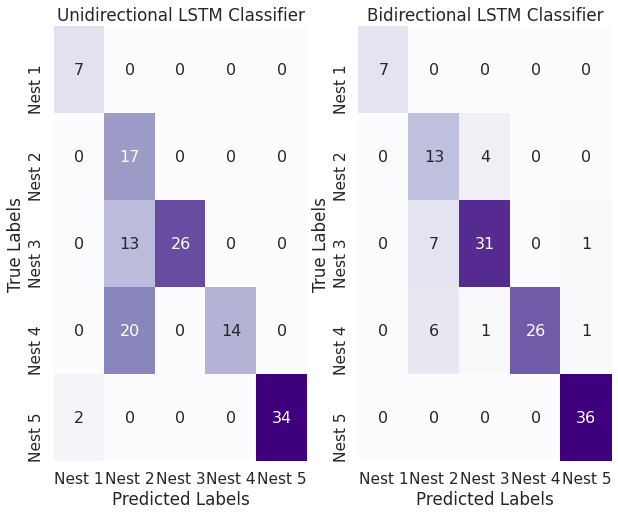

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(10,8))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat_lstm, cbar=False, cmap=cm.Purples,annot=True,annot_kws={"size": 16}, ax=axs[0])
axs[0].set_title('Unidirectional LSTM Classifier')
sns.heatmap(conf_mat_lstm_bidir, cbar=False, cmap=cm.Purples,annot=True,annot_kws={"size": 16}, ax=axs[1])
axs[1].set_title('Bidirectional LSTM Classifier')

plt.show()

In [ ]:
from os import walk

In [ ]:
search_path = '/content/gdrive/My Drive/ZFDataset/SavedModels/Final Architecture/LSTM/'
_, _, filenames = next(walk(search_path))

In [ ]:
Accuracy_Table = pd.DataFrame(columns=['Train Accuracy', 'Val Accuracy', 'Test Accuracy'])

for file in filenames:
  if 'Accuracy_Table_Test' in file:
    print(file)
    Acc_data = pd.read_csv(search_path+file, index_col=False)
    Acc_data = Acc_data.drop(columns=['Unnamed: 0'])
    Accuracy_Table = Accuracy_Table.append(pd.Series(Acc_data.mean(axis=0).values, index=Accuracy_Table.columns.values), ignore_index=True)

Accuracy_Table_Test_Random_3859.csv
Accuracy_Table_Test_Random_7857.csv
Accuracy_Table_Test_Random_7980.csv
Accuracy_Table_Test_Random_2999.csv
Accuracy_Table_Test_Random_3324.csv
Accuracy_Table_Test_Random_1778.csv
Accuracy_Table_Test_Random_329.csv
Accuracy_Table_Test_Random_5689.csv
Accuracy_Table_Test_Random_2746.csv
Accuracy_Table_Test_Random_8964.csv
Accuracy_Table_Test_Random_70.csv
Accuracy_Table_Test_Random_4786.csv
Accuracy_Table_Test_Random_2816.csv
Accuracy_Table_Test_Random_2405.csv
Accuracy_Table_Test_Random_2681.csv
Accuracy_Table_Test_Random_5769.csv
Accuracy_Table_Test_Random_9327.csv
Accuracy_Table_Test_Random_7867.csv
Accuracy_Table_Test_Random_4469.csv
Accuracy_Table_Test_Random_4928.csv
Accuracy_Table_Test_Random_5730.csv
Accuracy_Table_Test_Random_858.csv
Accuracy_Table_Test_Random_6775.csv
Accuracy_Table_Test_Random_5487.csv
Accuracy_Table_Test_Random_1464.csv
Accuracy_Table_Test_Random_7365.csv
Accuracy_Table_Test_Random_4313.csv
Accuracy_Table_Test_Random_9324.

In [ ]:
Accuracy_Table

,Train Accuracy,Val Accuracy,Test Accuracy
0,0.996839,0.997436,0.736090
1,0.997846,0.996154,0.735338
2,0.998564,0.993950,0.754637
3,0.997917,0.994163,0.750564
4,0.998105,0.994292,0.762707
5,0.997894,0.994804,0.768421
6,0.998195,0.994062,0.776047
7,0.998420,0.993497,0.778008
8,0.998532,0.993357,0.778195
9,0.998622,0.993509,0.777068


In [ ]:
Accuracy_Table.mean(axis=0).values

array([0.99803126, 0.99327075, 0.78533347])

In [ ]:
Accuracy_Table.std(axis=0).values

array([0.00159406, 0.00091698, 0.01989415])